## Cleaning

In [1]:
#import packages
import pandas as pd
from datetime import datetime

#Adjust DataFrame width
pd.set_option('display.width', 1000)

#Import Flights Data and drop unnecessary columns
flightsDF = pd.read_csv('flightlist_20200301_20200331.csv')
flightsDF = flightsDF.drop(columns = ['number', 'icao24', 'registration', 'altitude_1', 'latitude_2', 'longitude_2', 'altitude_2'])

#Get Airline symbol from callsign, shorten day to YY-MM-DD, fill Nulls
flightsDF['callsign'] = flightsDF['callsign'].str[:3]
flightsDF['day'] = flightsDF['day'].str[:10]
flightsDF = flightsDF.fillna('N/A')

#Import Airlines Data and name/drop unnecessary columns/duplicates
airlinesDF = pd.read_csv('airlines.txt', sep = ';', header = None, encoding = 'unicode_escape')
airlinesDF.columns = ['Airline', 'Airline_IATA', 'Airline_ICAO', 'Airline_Callsign', 'Airline_Country']
airlinesDF = airlinesDF.drop(columns=['Airline_IATA', 'Airline_Callsign'])
airlinesDF = airlinesDF.drop_duplicates(subset=['Airline_ICAO'])

#Import Airports (Origin) Data and name/drop unnecessary columns/duplicates
Origin_AirportsDF = pd.read_csv('airports.txt', sep = ';', header = None, encoding = 'unicode_escape')
Origin_AirportsDF.columns = ['Origin_Name', 'Origin_City', 'Origin_Country', 'Origin_IATA', 'Origin_ICAO', 'Origin_Latitude', 'Origin_Longitude', 'Origin_Altitude', 'Origin_Timezone', 'Origin_DST']
Origin_AirportsDF = Origin_AirportsDF.drop(columns=['Origin_IATA', 'Origin_Latitude', 'Origin_Longitude', 'Origin_Altitude', 'Origin_Timezone', 'Origin_DST'])
Origin_AirportsDF = Origin_AirportsDF.drop_duplicates(subset=['Origin_ICAO'])

#Import Airports (Destination) Data and name/drop unnecessary columns/duplicates
Destination_AirportsDF = pd.read_csv('airports.txt', sep = ';', header = None, encoding = 'unicode_escape')
Destination_AirportsDF.columns = ['Destination_Name', 'Destination_City', 'Destination_Country', 'Destination_IATA', 'Destination_ICAO', 'Destination_Latitude', 'Destination_Longitude', 'Destination_Altitude', 'Destination_Timezone', 'Destination_DST']
Destination_AirportsDF = Destination_AirportsDF.drop(columns=['Destination_IATA', 'Destination_Latitude', 'Destination_Longitude', 'Destination_Altitude', 'Destination_Timezone', 'Destination_DST'])
Destination_AirportsDF = Destination_AirportsDF.drop_duplicates(subset=['Destination_ICAO'])

#Import Aircrafts Data and name/drop unnecessary columns/duplicates
aircraftsDF = pd.read_csv('aircrafts.txt', sep = ';', header = None, encoding = 'unicode_escape')
aircraftsDF.columns = ['Aircraft', 'Aircraft_ICAO', 'Aircraft_IATA', 'Aircraft_Capacity', 'Aircraft_Country']
aircraftsDF = aircraftsDF.drop(columns=['Aircraft_IATA', 'Aircraft_Country'])
aircraftsDF = aircraftsDF.drop_duplicates(subset=['Aircraft_ICAO'])

#Merge flightsDF with Origin_AirportsDF
df = pd.merge(flightsDF, Origin_AirportsDF, how = 'left', left_on = 'origin', right_on = 'Origin_ICAO')

#Merge df with Destination_AirportsDF
df = pd.merge(df, Destination_AirportsDF, how = 'left', left_on = 'destination', right_on = 'Destination_ICAO')

#Merge df with airlinesDF
df = pd.merge(df, airlinesDF, how = 'left', left_on = 'callsign', right_on = 'Airline_ICAO')

#Merge df with aircraftsDF
df = pd.merge(df, aircraftsDF, how = 'left', left_on = 'typecode', right_on = 'Aircraft_ICAO')

#Replace unmatched Airlines with Callsign, replace ENY with Envoy Air
for row, col in df.iterrows():
    if pd.isnull(col['Airline']):
        df.loc[row, 'Airline'] = col['callsign']
        if col['callsign'] == 'ENY':
            df.loc[row, 'Airline'] = 'Envoy Air'

#Drop unnecessary columns
df = df.drop(columns = ['callsign', 'Origin_ICAO', 'Destination_ICAO', 'Airline_ICAO', 'Aircraft_ICAO', 'typecode'])

#Reorder Columns
df = df[['day', 'Airline', 'Aircraft', 'Airline_Country', 'Aircraft_Capacity', 'firstseen', 'latitude_1', 'longitude_1', 'origin', 'Origin_Name', 'Origin_City', 'Origin_Country', 'lastseen', 'destination', 'Destination_Name', 'Destination_City', 'Destination_Country']]

#Rename Columns
df = df.rename(columns = {"day": "Day", "origin": "Origin", 'latitude_1':'Origin_Lat', 'longitude_1':'Origin_Long',"destination": "Destination", "firstseen": "First_Seen", "lastseen": "Last_Seen"})

#Fill nulls and convert to string
df[['Airline', 'Aircraft', 'Airline_Country', 'Origin', 'Origin_Name', 'Origin_City', 'Origin_Country', 'Destination', 'Destination_Name', 'Destination_City', 'Destination_Country']] = df[['Airline', 'Aircraft', 'Airline_Country', 'Origin', 'Origin_Name', 'Origin_City', 'Origin_Country', 'Destination', 'Destination_Name', 'Destination_City', 'Destination_Country']].fillna('N/A').astype('str')

#Fill nulls and convert to int
df[['Aircraft_Capacity']] = df[['Aircraft_Capacity']].fillna(0).astype('int')

#Convert to datetime
df['First_Seen'] = pd.to_datetime(df['First_Seen'])

#Add Count column
df['Count'] = 1

#Find Unique Airlines
airlines = df['Airline'].unique()

#Initialize Cargo Airlines
cargo_airlines = ['Federal Express', 'United Parcel Service']

#Find/add Cargo airlines to list
for i in airlines:
    if 'Cargo' in i:
        cargo_airlines.append(i)
        
#Filter df for Cargo Airlines
cargoDF = df[df['Airline'].isin(cargo_airlines)] 

#Filter df for Passenger flights
flightsDF = df[~df['Airline'].isin(cargo_airlines)] 

## Data Visualization

###	A map of all flights where they were first seen at different points in March 2020, illustrating the number of flights taking place on a given day.

In [2]:
#Import Packages
import geopandas
import keplergl

#Define GeoPandas DataFrame
gdf = geopandas.GeoDataFrame(flightsDF, geometry=geopandas.points_from_xy(flightsDF['Origin_Long'], flightsDF['Origin_Lat']))

#Remove Unnecessary columns
gdf = gdf.drop(columns = ['Day','Airline', 'Airline_Country', 'Aircraft','Aircraft_Capacity','Origin_Lat','Origin_Long', 'Origin','Origin_Name','Origin_City','Origin_Country','Last_Seen','Destination','Destination_Name','Destination_City','Destination_Country','Count'])

#Define Map
gdf_map = keplergl.KeplerGl(height = 700, data = {'data' : gdf})

#Display
gdf_map

#To display time series, click arrow in top left corner, then select Filters and add First_Seen

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data':                        First_Seen                                           geometry
0 …

### The total number of flights in March 2020.

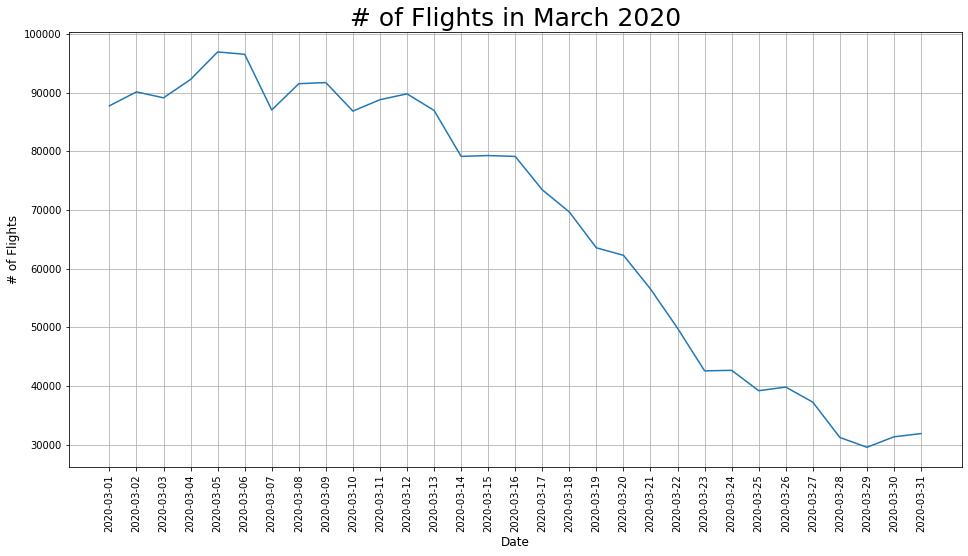

In [3]:
#Import Packages
import matplotlib.pyplot as plt

#Set Fig Size
plt.figure(figsize=(16,8))

#Initialize dicionary
daily_count = {}

#Create Daily Count DataFrame
daily_countDF = pd.DataFrame(flightsDF.groupby('Day').count())

#Update dictionary with daily flight count
for row, col in daily_countDF.iterrows():
    daily_count.update({row : col['Count']})

#Define X and Y
X = daily_count.keys()
y = daily_count.values()

#Plot Configuration
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=12)
plt.ylabel('# of Flights', fontsize=12)
plt.title('# of Flights in March 2020', fontsize=25)
plt.grid()

#Plot
plt.plot(X, y)
plt.show()

###	The number of flights at top airlines/airports around the world March 2020.

In [4]:
#Import packages
import numpy as np
import bar_chart_race as bcr
from IPython.display import display

##https://superuser.com/questions/624561/install-ffmpeg-on-os-x

#Loop for Airlines and Airports
for i in ['Airline', 'Origin_Name']:
    
    #Find counts for each Airline/Airport
    top = pd.DataFrame(flightsDF.groupby(i, as_index=False).count())

    #Shrink to Airline/Airport and Count
    top = top[[i, 'Count']]
    
    #Remove N/A
    top = top[top[i] != 'N/A']
    
    #Sort for top 10 Airlines/Airports
    top = top.sort_values(by = ['Count'], ascending = False).head(10)

    #Convert to list
    top = list(top[i])
    
    #Filter flightsDF for top Airlines/Airports
    top_DF = flightsDF[flightsDF[i].isin(top)]
    
    #Pivot data (Y = Day, X = Airline/Airport)
    top_DF = pd.pivot_table(top_DF, values = 'Count', index = 'Day', columns = i, aggfunc=np.sum)
    
    #Change Origin_Name to Airport
    if i == 'Origin_Name':
        i = 'Airport'
        
    #Create bar chart race
    viz = bcr.bar_chart_race(top_DF, figsize=(5, 3), n_bars=10, filter_column_colors=True, title='# of flights at top '+str(i)+'s in March 2020')

    #Display bar chart race
    display(viz)

/Users/MitchellBreeden/opt/anaconda3/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/Users/MitchellBreeden/opt/anaconda3/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


/Users/MitchellBreeden/opt/anaconda3/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/Users/MitchellBreeden/opt/anaconda3/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


## Descriptive Analytics


### The total number of passenger/cargo flights taken on average per day before and after the pandemic started.

In [5]:
#Define function (i = DataFrame, cap = Capacity)
def avg_flights(i, cap):
    
    #Define daily_count dictionary
    daily_count = {}
    
    if cap == False:
        #Find number of daily flights and update dicitonary
        daily_countDF = pd.DataFrame(i.groupby('Day').count())
        for row, col in daily_countDF.iterrows():
            daily_count.update({row : col['Count']})
    else:
        #Find daily capacity and update dictionary
        daily_countDF = pd.DataFrame(i.groupby('Day')['Aircraft_Capacity'].sum())
        for row, col in daily_countDF.iterrows():
            daily_count.update({row : col['Aircraft_Capacity']})

    #Initialize variables
    flights_before = 0
    days_before = 0

    flights_after = 0
    days_after = 0

    #Split data based on before or after March 15, 2020 and count number of days
    for key, val in daily_count.items():
        if pd.to_datetime(key) >= datetime.strptime('2020-03-01', "%Y-%m-%d") and pd.to_datetime(key) <= datetime.strptime('2020-03-15', "%Y-%m-%d"):
            flights_before += val
            days_before += 1
        elif pd.to_datetime(key) > datetime.strptime('2020-03-15', "%Y-%m-%d"):
            flights_after += val
            days_after += 1

    #Find Daily Average
    avg_flights_before = round((flights_before/days_before),2)
    avg_flights_after = round((flights_after/days_after),2)
    
    #Find percent difference
    percent_change = ((avg_flights_before - avg_flights_after)/avg_flights_before)*-100

    #Print outputs
    print('Before March 15, 2020:',"{:,}".format(avg_flights_before))
    print('After March 15, 2020:',"{:,}".format(avg_flights_after))
    print('Change:',round(percent_change,2),'%')

#Call function for each DataFrame
print('Average daily # of passenger flights')
avg_flights(flightsDF, False)
print('\n')

print('Average daily # of passengers')
avg_flights(flightsDF, True)
print('\n')

print('Average daily # of cargo flights')
avg_flights(cargoDF, False)

Average daily # of passenger flights
Before March 15, 2020: 88,899.67
After March 15, 2020: 48,762.88
Change: -45.15 %


Average daily # of passengers
Before March 15, 2020: 6,083,030.93
After March 15, 2020: 3,141,443.12
Change: -48.36 %


Average daily # of cargo flights
Before March 15, 2020: 1,214.93
After March 15, 2020: 1,264.5
Change: 4.08 %


## Inferential analytics

### Which airlines were impacted the most in terms of flights taken before and after the pandemic started. 

In [6]:
#Filter to just US based airlines
us_flightsDF = flightsDF[flightsDF['Airline_Country'] == 'United States']

#Split us_flightsDF to before March 15 and after
preDF = us_flightsDF[(pd.to_datetime(us_flightsDF['Day']) >= datetime.strptime('2020-03-01', "%Y-%m-%d")) & (pd.to_datetime(us_flightsDF['Day']) <= datetime.strptime('2020-03-15', "%Y-%m-%d")) ]
postDF = us_flightsDF[pd.to_datetime(us_flightsDF['Day']) > datetime.strptime('2020-03-15', "%Y-%m-%d")]

#Count number of flights and format
preDF = pd.DataFrame(preDF['Airline'].value_counts()).reset_index()
preDF.columns=['Airline', 'Pre_Count']

#Count number of flights and format
postDF = pd.DataFrame(postDF['Airline'].value_counts()).reset_index()
postDF.columns = ['Airline', 'Post_Count']

#Merge pre and post
pre_post = pd.merge(preDF, postDF, how = 'outer')

#Calculate pre and post difference
pre_post['Difference'] = pre_post['Post_Count'] - pre_post['Pre_Count']

#Calculate percent difference
pre_post['Percent'] = round((((pre_post['Pre_Count'] - pre_post['Post_Count'])/pre_post['Pre_Count'])*-100),2)

#Filter to only airlines with more than 100 flights in pre
pre_post = pre_post[pre_post['Pre_Count'] > 100]

#Sort by difference and percent
pre_post = pre_post.sort_values(by = ['Difference', 'Percent']).reset_index(drop = True)

#Display
pre_post

,Airline,Pre_Count,Post_Count,Difference,Percent
0,Delta Air Lines,45737.0,28192.0,-17545.0,-38.36
1,American Airlines,44630.0,29432.0,-15198.0,-34.05
2,United Airlines,31512.0,18798.0,-12714.0,-40.35
3,Southwest Airlines,53973.0,41785.0,-12188.0,-22.58
4,SkyWest,35277.0,29421.0,-5856.0,-16.60
5,JetBlue Airways,14526.0,9808.0,-4718.0,-32.48
6,Republic Airlines,14673.0,11251.0,-3422.0,-23.32
7,Mesa Airlines,9794.0,7263.0,-2531.0,-25.84
8,Allegiant Air,5673.0,3292.0,-2381.0,-41.97
9,Atlantic Southeast Airlines,6187.0,4282.0,-1905.0,-30.79


## Advanced analytics (ML, etc.) 

### # of Flights in March 2020 vs. Predicted for March 2020 and 30 days after.

Intercept: 105013.26943980425
Slope: [-2399.63936663]


/var/folders/jt/vpf3gdr52kgcdxzrr3m16hxw0000gp/T/ipykernel_36180/3865412540.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flightsDF['Day'] = pd.to_datetime(flightsDF['Day'].astype('str'))


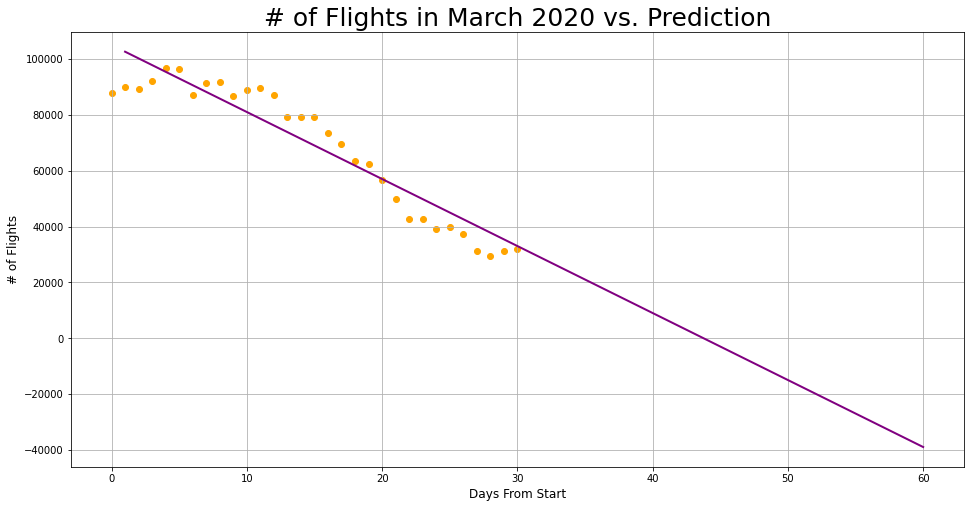

In [7]:
#Import Packages
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#Set Fig Size
plt.figure(figsize=(16,8))

#Format datetime column
flightsDF['Day'] = pd.to_datetime(flightsDF['Day'].astype('str'))

#Create time series
ts = pd.DataFrame(flightsDF.groupby('Day')['Count'].sum().rename("Flights"))
ts['days_from_start'] = (ts.index - ts.index[0]).days

#Iniate X, y
X = ts['days_from_start'].values.reshape(-1, 1)
y = ts['Flights'].values

#Create test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Create/fit model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Print Intercept/Slope
print('Intercept: ' + str(model.intercept_))
print('Slope: ' + str(model.coef_))

#Plot Flights
plt.scatter(X, y, c='orange', marker='o')

#Find predicted values
dict = {}
for i in range(1,61):   
    new_X = np.array(i, dtype=object).reshape(1, -1)
    new_X = model.predict(new_X)
    dict.update({new_X[0]:i})

#Iniate X, y
X = dict.values()
y = dict.keys()

#Plot line of best fit/prediction
plt.plot(X, y, color="purple", linewidth=2)

#Plot settings
plt.xlabel('Days From Start', fontsize=12)
plt.ylabel('# of Flights', fontsize=12)
plt.title('# of Flights in March 2020 vs. Prediction', fontsize=25)
plt.grid()

#Display
plt.show()